In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import metpy
import metpy.io
import datetime

import xarray as xr

In [2]:
# Change default to be better for skew-T
plt.rcParams['figure.figsize'] = (9, 9)

In [3]:
# Upper air data can be obtained using the siphon package, but for this example we will use
# some of MetPy's sample data.

#col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

#df = pd.read_fwf(get_test_data('jan20_sounding.txt', as_file_obj=False),
               #  skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
#df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
             #          ), how='all').reset_index(drop=True)

In [4]:
metpy.__version__

'0.0.post4831+gc909005.d20230517'

In [5]:
gemdata = metpy.io.GempakGrid('19z06252019.gem')

valid_time = datetime.datetime(2019, 6, 25, 19, 0)

tmpk = gemdata.gdxarray(parameter='TMPK', coordinate='PRES', date_time=valid_time)

relh = gemdata.gdxarray(parameter='RELH', coordinate='PRES', date_time=valid_time)

z = gemdata.gdxarray(parameter='HGHT', coordinate='PRES', date_time=valid_time)

z = [da.squeeze('time') for da in z]

tmpk = [da.squeeze('time') for da in tmpk]

relh = [da.squeeze('time') for da in relh]

ds = xr.merge((xr.merge(tmpk),xr.merge(relh),xr.merge(z)))

ds = ds.metpy.parse_cf()

ds= ds.metpy.assign_latitude_longitude()

In [6]:
ds

<xarray.Dataset>
Dimensions:    (pres: 37, x: 301, y: 225)
Coordinates:
  * pres       (pres) int64 100 125 150 175 200 225 ... 875 900 925 950 975 1000
  * x          (x) float32 -3.332e+06 -3.312e+06 ... 2.743e+06 2.763e+06
  * y          (y) float32 2.279e+06 2.299e+06 2.32e+06 ... 6.81e+06 6.83e+06
    time       datetime64[ns] 2019-06-25T19:00:00
    metpy_crs  object Projection: lambert_conformal_conic
    latitude   (y, x) float64 16.28 16.32 16.36 16.4 ... 55.61 55.57 55.52 55.48
    longitude  (y, x) float64 -126.1 -126.0 -125.8 ... -57.9 -57.64 -57.38
Data variables:
    tmpk       (pres, y, x) float32 195.7 195.9 196.0 ... 273.9 273.9 273.9
    relh       (pres, y, x) float32 36.76 35.56 34.36 ... 99.73 99.73 99.73
    z          (pres, y, x) float32 1.665e+04 1.665e+04 ... 105.9 105.9
Attributes:
    gempak_grid_type:  forecast

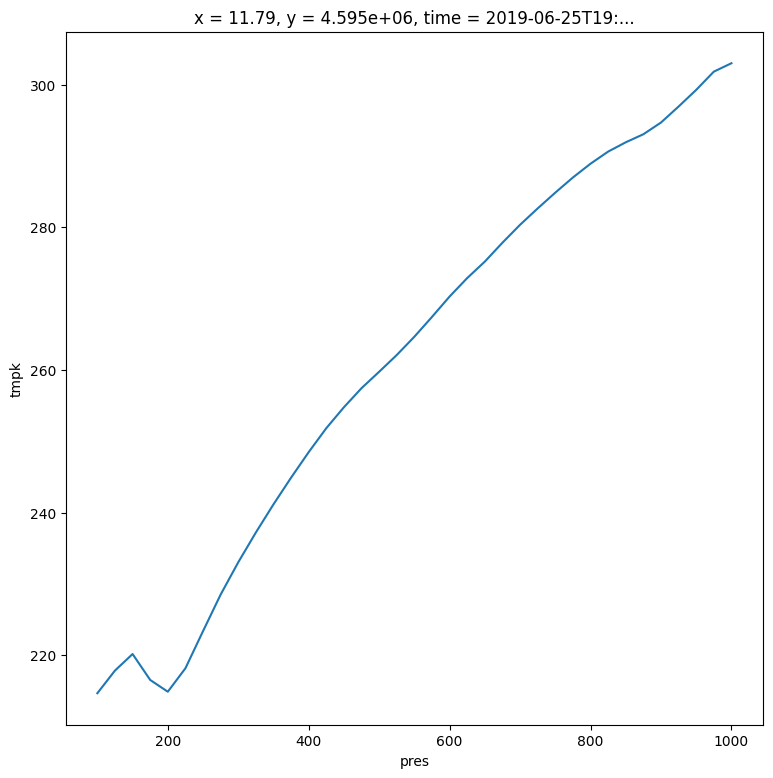

In [7]:
ds['tmpk'][:,114,164].plot()

In [8]:
ds['latitude'][116,156].values

array(40.68276973)

In [9]:
ds['longitude'][116,156].values

array(-96.85233374)

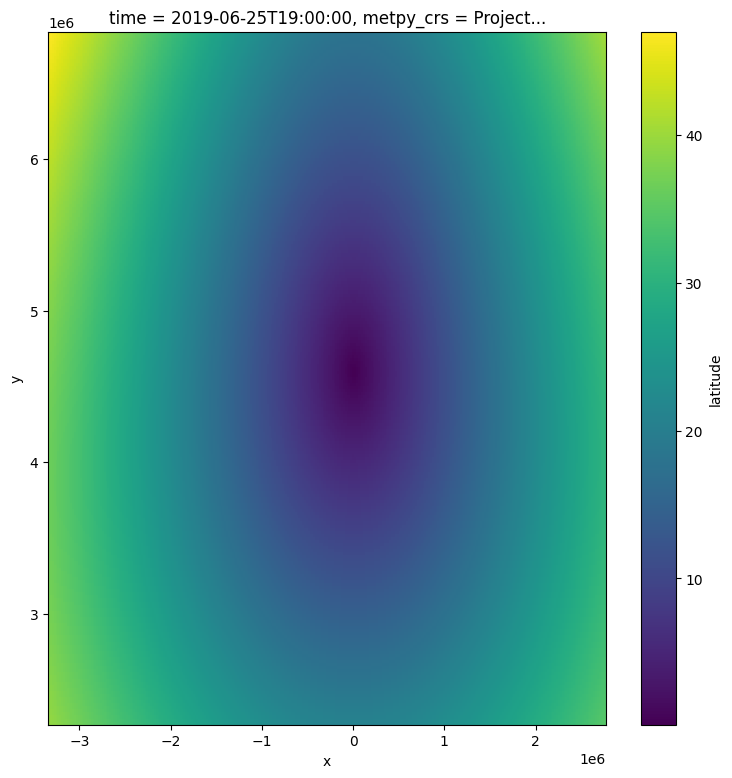

In [10]:
mylat = 40.40
mylon = -94.92

distances = np.hypot(mylat-ds['latitude'], mylon-ds['longitude'])

distances.plot()

In [11]:
minima = distances.argmin(...)

In [12]:
myx = minima['x'].values
myy = minima['y'].values

In [13]:
myx

array(164)

In [14]:
myy

array(114)

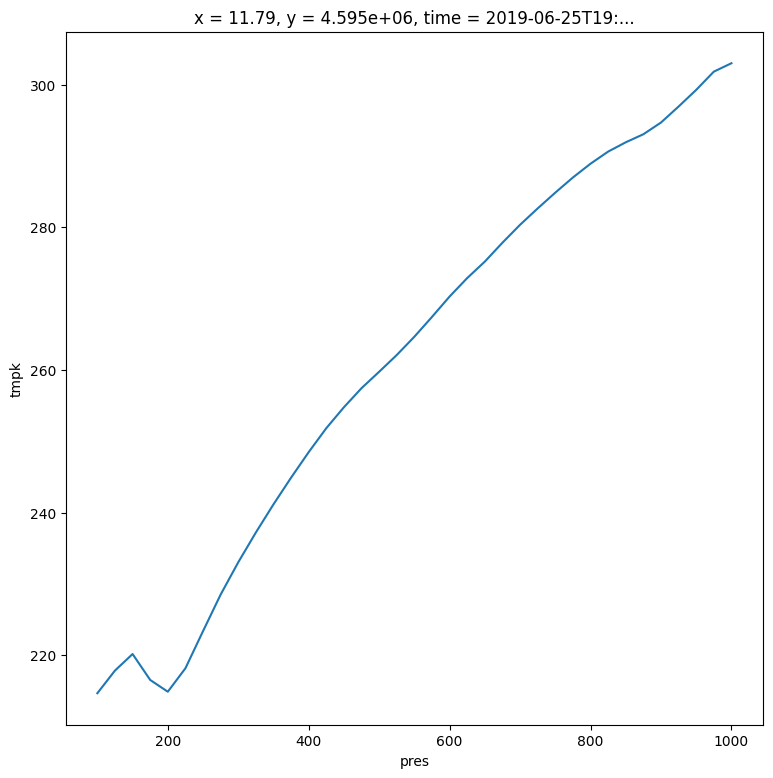

In [15]:
ds['tmpk'][:,myy,myx].plot()

In [16]:
#We will pull the data out of the example dataset into individual variables and assign units.

#p = ds['pres'].values * units.hPa
#T = ds['tmpk'].values * units.degC
#RH = ds['relh'].values
#wind_speed = ds['speed'].values * units.knots
#wind_dir = ds['direction'].values * units.degrees
#u, v = mpcalc.wind_components(wind_speed, wind_dir)

#mpcalc.most_unstable_cape_cin(p,T,Td) 


In [17]:
pfleRH = ds['relh'][:,myy,myx]*units.percent

In [18]:
p = ds['pres'].values*units.hPa

In [19]:
pfleT = ds['tmpk'][:,myy,myx]*units.kelvin

In [20]:
dwpt = mpcalc.dewpoint_from_relative_humidity(pfleT,pfleRH)

In [21]:
zpfl = ds['z'][:,myy,myx]*units.meters

In [22]:
zpfl = zpfl[::-1]

In [23]:
dwpt = dwpt[::-1]

In [24]:
p = p[::-1]

In [25]:
pfleT = pfleT[::-1]

In [26]:
sfcpres = gemdata.gdxarray(parameter='PRES', coordinate='NONE', date_time=valid_time)[0]

In [27]:
sfcpres = sfcpres.isel(x=myx,y=myy).squeeze('none').squeeze('time')*units.hPa

In [28]:
sfcpres

<xarray.DataArray 'p' ()>
<Quantity(976.037476, 'hectopascal')>
Coordinates:
    time       datetime64[ns] 2019-06-25T19:00:00
    none       int64 0
    x          float32 11.79
    y          float32 4.595e+06
    metpy_crs  object Projection: lambert_conformal_conic

In [29]:
closest=1000*units.hPa
for k,pres in enumerate(p):
    #print(k,pres,abs(pres-sfcpres)) 
    diff=abs(pres-sfcpres)
    if diff < closest:
        closest=diff
        closestk=k
print(closest)
print(closestk)
        


<xarray.DataArray 'p' ()>
<Quantity(1.03747559, 'hectopascal')>
Coordinates:
    time       datetime64[ns] 2019-06-25T19:00:00
    none       int64 0
    x          float32 11.79
    y          float32 4.595e+06
    metpy_crs  object Projection: lambert_conformal_conic
1


In [30]:
mpcalc.mixed_layer_cape_cin(p[closestk::],pfleT[closestk::],dwpt[closestk::]) 
#mpcalc.mixed_layer_cape_cin(p[closestk::],mixT,mixTd,z[closestk::],True,pfleT[closestk::],dwpt[closestk::]) 

(1340.055524797444 <Unit('joule / kilogram')>,
 -170.262003912938 <Unit('joule / kilogram')>)

In [31]:
p[closestk::]

Magnitude,[975 950 925 900 875 850 825 800 775 750 725 700 675 650 625 600 575 550 525 500 475 450 425 400 375 350 325 300 275 250 225 200 175 150 125 100]
Units,hectopascal


975 hectopascal 301.62772471614466 kelvin 15.18265474645483 degree_Celsius
802.9021454388576 hectopascal 285.3471534949194 kelvin
2008.0916369424276 meter
141
141
141


/local_homes/jte27/research/MetPy/src/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/jte27/miniconda3/envs/dilCAPE/lib/python3.10/site-packages/pint/quantity.py:1583: RuntimeWarning: invalid value encountered in double_scalars
  return other**new_self._magnitude
/local_homes/jte27/research/MetPy/src/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


[nan nan] hectopascal
[<Quantity([nan], 'kelvin')>, <Quantity([nan], 'kelvin')>]
2008.0916369424276 meter
141
141
141
[nan nan] hectopascal
[<Quantity([nan], 'kelvin')>, <Quantity([nan], 'kelvin')>]


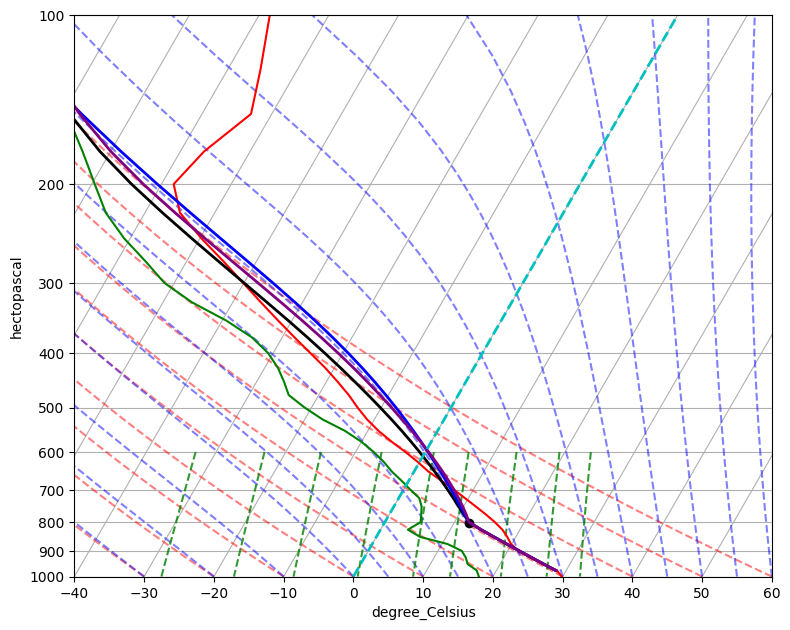

In [32]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, pfleT.values-273.15, 'r')
skew.plot(p, dwpt, 'g')
#skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

mixp,mixT,mixTd = mpcalc.mixed_parcel(p[closestk:],pfleT[closestk:],dwpt[closestk:])

print(mixp,mixT,mixTd)

lcl_pressure, lcl_temperature = mpcalc.lcl(mixp,mixT,mixTd)

print(lcl_pressure, lcl_temperature)

#print(p[closestk::], pfleT[closestk::], z[closestk::], dwpt[closestk::])

#unmodified CAPE profile

parcel_prof0 = mpcalc.parcel_profile(p[closestk:], mixT, mixTd)


# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p[closestk:], mixT, mixTd, zpfl[closestk:], True, pfleT[closestk:],dwpt[closestk:])

# Caculate saturated parcel porfile

parcel_prof2 = mpcalc.parcel_profile(p[closestk:], mixT, mixTd, zpfl[closestk:], True, pfleT[closestk:],pfleT[closestk:])

# Plot profiles together 
#parcel_prof = mpcalc.parcel_profile(p[closestk:], mixT, mixTd, zpfl[closestk:], True, pfleT[closestk:closestk+len(zpfl)], dwpt[closestk:closestk+len(zpfl)])
#parcel_prof2 = mpcalc.parcel_profile(p[closestk:], pfleT[closestk:closestk+len(zpfl)], dwpt[closestk:closestk+len(zpfl)])

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p[closestk:], parcel_prof, 'k', linewidth=2)
skew.plot(p[closestk:], parcel_prof0, 'b', linewidth=2)
skew.plot(p[closestk:], parcel_prof2, 'purple', linewidth=2)

# Shade areas of CAPE and CIN
#skew.shade_cin(p[closestk:], pfleT[closestk:], parcel_prof, dwpt[closestk:])
#skew.shade_cape(p[closestk:], pfleT[closestk:], parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

In [33]:
#dilCAPE calculation
modCAPE = mpcalc.cape_cin(p[closestk:],pfleT[closestk:],dwpt[closestk:],parcel_prof)
print(modCAPE)

(<Quantity(464.942258, 'joule / kilogram')>, <Quantity(-157.270173, 'joule / kilogram')>)


In [34]:
print(parcel_prof)
print(pfleT)

[301.62772471614466 299.3974604493739 297.1248707416933 294.807975036161 292.4446419062955 290.0325728738999 287.56928395817107 285.190935419133 283.8344830320914 282.43789847354554 280.9822524567311 279.4529096612797 277.82989548336894 276.1041445294573 274.27077810865467 272.32805427108303 270.24117860034863 268.00513357957817 265.60104059115963 263.01555300041355 260.23894604442705 257.25705918899337 254.04005727550035 250.55408276785522 246.76200909772805 242.6266852207756 238.10583146893194 233.18173504648365 227.8285992112001 222.00754314040893 215.68397596873848 208.85183824017892 201.64474888339004 194.18412607858187 186.21039404820377 nan] kelvin
<xarray.DataArray 'tmpk' (pres: 37)>
<Quantity([303.01282 301.83185 299.27756 296.9441  294.69797 293.05508 291.92773
 290.6232  288.92603 286.99344 284.87054 282.65845 280.36258 277.85266
 275.20508 272.8955  270.30792 267.44974 264.6729  262.10867 259.75864
 257.4586  254.78595 251.84969 248.49072 244.9146  241.16971 237.2247
 233.0

In [35]:
#dilCAPE saturated
modCAPE = mpcalc.cape_cin(p[closestk:],pfleT[closestk:],pfleT[closestk:],parcel_prof2)
print(modCAPE)

(<Quantity(802.789724, 'joule / kilogram')>, <Quantity(0.0, 'joule / kilogram')>)


In [36]:
parcel_profTest = mpcalc.parcel_profile(p[closestk:],pfleT[closestk],dwpt[closestk])
print(parcel_profTest)

[301.83184814453125 299.6000745695934 297.3259469104434 295.007483269818 292.642550778815 290.2288494037664 287.7638934828607 286.57675543127044 285.38429290386676 284.1396489672942 282.83796281821583 281.473679171199 280.04043278603365 278.5308837245871 276.93652837876135 275.24745745076984 273.45206298093706 271.5366859836598 269.48517221980313 267.27834464503167 264.89338127347486 262.30311382306195 259.4752842399856 256.3718910718989 252.94883546912274 249.15615005859823 244.93924583364165 240.24133972647914 235.00655704365366 229.18187740621462 222.71487105729324 215.54427375708997 207.58197051018914 198.6857426185912 188.61805598983418 176.972469254497] kelvin
